In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

In [2]:
lang_df = pd.read_csv('../data/language_vote_details.csv', low_memory=False)
df = pd.read_csv('../data/cleaned2.csv', low_memory=False)
ranks = pd.read_csv('../data/boardgames_ranks.csv', low_memory=False)

df['categories'] = df['categories']\
    .apply(lambda x: ast.literal_eval(x))
df['mechanics'] = df['mechanics']\
    .apply(lambda x: ast.literal_eval(x))

In [3]:
ranks.rename(columns={"id":"@id"}, inplace = True)
lang_df.rename(columns={"Language Dependency": "lang"}, inplace = True)

df

,@type,@id,name,description,minplayers,maxplayers,poll,playingtime,minplaytime,maxplaytime,...,seriescode,issueindex,year,categories,mechanics,family,implementation,designer,artist,publisher
0,boardgame,1,Die Macher,Die Macher is a game about seven sequential po...,3,5,"[{'@name': 'suggested_numplayers', '@title': '...",240,240,240,...,NaN,NaN,1986,"[Economy / Industry, Political, Bluffing / Neg...","[Simultaneous Action Selection, Alliances, Han...","['Country: Germany', 'Digital Implementations:...",[],['Karl-Heinz Schmiel'],"['Bernd Brunnhofer', 'Marcus Gschwendtner', 'H...","['Hans im Glück', 'Moskito Spiele', 'Ediciones..."
1,boardgame,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,3,4,"[{'@name': 'suggested_numplayers', '@title': '...",30,30,30,...,NaN,NaN,1981,"[Fantasy, Card Game]",[Trick-taking],"['Components: Gems/Crystals', 'Creatures: Drag...","['Indulgence', ""Coup d'État""]","['G. W. ""Jerry"" D\'Arcey']",['Bob Pepper'],"['E. S. Lowe Company Inc.', 'Milton Bradley']"
2,boardgame,3,Samurai,Samurai is set in medieval Japan. Players comp...,2,4,"[{'@name': 'suggested_numplayers', '@title': '...",60,30,60,...,NaN,NaN,1998,"[Abstract Strategy, Historical Setting]","[Grid-Based, Tile Placement, Hand Management, ...",['Components: Map (Continental / National scal...,['Samurai: The Card Game'],['Reiner Knizia'],['Franz Vohwinkel'],"['Fantasy Flight Games', 'Hans im Glück', '999..."
3,boardgame,4,Tal der Könige,When you see the triangular box and the luxuri...,2,4,"[{'@name': 'suggested_numplayers', '@title': '...",60,60,60,...,NaN,NaN,1992,[Historical Setting],"[Auction, Set Collection, Area Majority / Infl...","['Containers: Triangular Boxes', 'Country: Egy...",[],['Christian Beierer'],['Thomas di Paolo'],['KOSMOS']
4,boardgame,5,Acquire,"In Acquire, each player strategically invests ...",2,6,"[{'@name': 'suggested_numplayers', '@title': '...",90,90,90,...,NaN,NaN,1963,"[Economy / Industry, Territory Building]","[Victory Points as a Resource, Stock Holding, ...","['Components: 9 x 12 Grids', 'Digital Implemen...",[],['Sid Sackson'],"['Eric Hibbeler', ""Scott O'Gara"", 'Scott Okumu...","['3M', 'The Avalon Hill Game Co', 'Avalon Hill..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119483,boardgame,413783,Chinese War of Liberation: Prairie Fire Follow...,This Chinese War of Liberation System includes...,2,2,"[{'@name': 'suggested_numplayers', '@title': '...",0,0,0,...,NaN,NaN,2022,[War],[Grid-Based],"['Country: China', 'History: Chinese Civil War...",[],[],[],['War Drum Games']
119484,boardgame,413784,Lucky Xmas,In Lucky Xmas you are allowed to use Santa's m...,1,5,"[{'@name': 'suggested_numplayers', '@title': '...",50,25,50,...,NaN,NaN,2025,"[Card Game, Abstract Strategy, Puzzle]","[Multi-Use Cards, Pattern Building, Market, Ti...",['Admin: Upcoming Releases'],[],['Christof Van Conkelberge'],['Christof Van Conkelberge'],['(Looking for a publisher)']
119485,boardgame,413838,Sakana Stack,Sakana Stack is a climbing/shedding card game ...,3,5,"[{'@name': 'suggested_numplayers', '@title': '...",30,15,30,...,NaN,NaN,2024,[Card Game],"[Trick-taking, Ladder Climbing]","['Admin: Upcoming Releases', 'Card Games: Clim...",[],['Mike Petchey'],['Joss Petchey'],['Huff No More']
119486,boardgame,413839,激闘 関ヶ原 (Fierce battle at Sekigahara),&#230;&#191;&#128;&#233;&#151;&#152; &#233;&#1...,2,0,"[{'@name': 'suggested_numplayers', '@title': '...",0,0,0,...,NaN,NaN,2023,"[War, Historical Setting]",[Grid-Based],"['Cities: Sekigahara (Japan)', 'History: Sengo...",[],"['Nobuo Kato', 'Takatsugu Nakazawa']",[],['Game Journal']


# **Analyses of Language Dependencies for Boardgames**

**Objective:** 

Assessment of boardgames available on Boardgame Geek API (BGG) to determine trends concerning language dependencies for game categories, game mechanics and rankings. Following sections prepare the relevant data and plot trends.

## **Part 1: Metrics for Game Titles, Rankings, and Language Dependencies**

### **1A. Data Prep**

In [4]:
# Data prep. Creating df containing columns for id, name, year, language, ranks 

merge_df = pd.merge(df[["@id", "name" , "year"]], ranks[["@id","rank"]], on = "@id", how = "inner")
games_df = pd.merge(merge_df, lang_df[["@id","lang"]], on = "@id", how = "inner")   

games = games_df.copy()
games.dropna(inplace = True)
display(games.head(2))
games.info()

,@id,name,year,rank,lang
0,1,Die Macher,1986,409,Not Dependent
1,2,Dragonmaster,1981,4819,Somewhat


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119253 entries, 0 to 119252
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   @id     119253 non-null  int64 
 1   name    119253 non-null  object
 2   year    119253 non-null  int64 
 3   rank    119253 non-null  int64 
 4   lang    119253 non-null  object
dtypes: int64(3), object(2)
memory usage: 4.5+ MB


In [5]:
# bin by decade
bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ["1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]
games["decade"] = pd.cut(games["year"], bins = bins, labels = labels, right = False)


#display df output and some ranking info
no_rank = (games["rank"] != 0).sum()
display(games.head())
print(f"Number of games that have rankings: {no_rank}")
print(f"Lowest game ranking is: {games['rank'].max()}")

,@id,name,year,rank,lang,decade
0,1,Die Macher,1986,409,Not Dependent,1980s
1,2,Dragonmaster,1981,4819,Somewhat,1980s
2,3,Samurai,1998,266,Not Dependent,1990s
3,4,Tal der Könige,1992,6440,Not Dependent,1990s
4,5,Acquire,1963,335,Not Dependent,1960s


Number of games that have rankings: 25807
Lowest game ranking is: 25809


In [6]:
# add columns for grouped game ranks (e.g. games ranked 1 - 100, games ranked 101-500, etc)

def rank_groups(value, label):
    if value == "":
        return pd.NA
    value = int(value)
    
    if label == grouped_rankings[0] and value <= 100:
        return "True"
    elif label == grouped_rankings[1] and value >= 101 and value <= 500:
        return "True"
    elif label == grouped_rankings[2] and value >= 501 and value <= 1000:
        return "True"
    elif label == grouped_rankings[3] and value >= 1001 and value <= 2500:
        return "True"
    elif label == grouped_rankings[4] and value >= 2501 and value <= 4999:
        return "True"
    elif label == grouped_rankings[5] and value > 5000:
        return "True"
    else:
        return pd.NA

grouped_rankings = ["1 - 100", "101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"]


for label in grouped_rankings:
    games[label] = games["rank"].apply(lambda row: rank_groups(row, label))
    
    
games

,@id,name,year,rank,lang,decade,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
0,1,Die Macher,1986,409,Not Dependent,1980s,NaN,True,NaN,NaN,<NA>,<NA>
1,2,Dragonmaster,1981,4819,Somewhat,1980s,NaN,<NA>,NaN,NaN,True,<NA>
2,3,Samurai,1998,266,Not Dependent,1990s,NaN,True,NaN,NaN,<NA>,<NA>
3,4,Tal der Könige,1992,6440,Not Dependent,1990s,NaN,<NA>,NaN,NaN,<NA>,True
4,5,Acquire,1963,335,Not Dependent,1960s,NaN,True,NaN,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
119248,413397,Sideboards,2024,0,Not Dependent,2020s,True,NaN,NaN,NaN,NaN,NaN
119249,413403,Minecraft Explorers,2024,0,Not Dependent,2020s,True,NaN,NaN,NaN,NaN,NaN
119250,413416,Garden Heist,2024,0,Not Dependent,2020s,True,NaN,NaN,NaN,NaN,NaN
119251,413435,Oh My Pigeons!,2024,0,Not Dependent,2020s,True,NaN,NaN,NaN,NaN,NaN


In [7]:
games = games.convert_dtypes()

In [8]:
#creating df for games that have been ranked, non ranked were dropped

drop_zero = games["rank"] == 0
games_rankings = games.drop(games[drop_zero].index)


### **1B. Pivots and Plots**

In [9]:
#Pivoted to see if anything interesting regarding language dependencies and game popularity (grouped by rankings groups)

rankings_vs_lang = pd.pivot_table(games_rankings, 
                                index = 'lang', 
                                values = ["1 - 100", "101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"],
                                aggfunc='count')

rankings_vs_lang = rankings_vs_lang[grouped_rankings]

#updated the table's values to percentages.

def convert_to_percent(col):
    total_sum = col.sum()
    return col / total_sum

rankings_vs_lang_perc = rankings_vs_lang.apply(convert_to_percent) 

display(rankings_vs_lang_perc)

,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
lang,,,,,,
Extensively,0.36,0.1750,0.160,0.155333,0.140056,0.076993
Fully,0.03,0.0275,0.028,0.026000,0.021609,0.031528
Moderately,0.25,0.2750,0.214,0.198000,0.202481,0.169654
Not Dependent,0.29,0.3675,0.398,0.419333,0.446178,0.615322
Somewhat,0.07,0.1550,0.200,0.201333,0.189676,0.106503


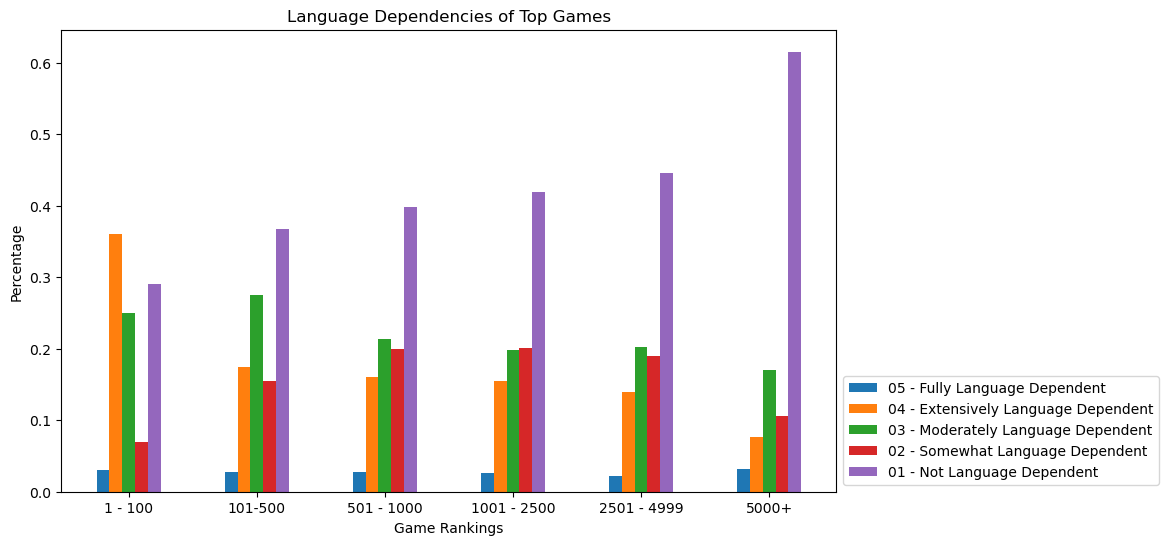

In [10]:
#setting up df info for plotting

perc_fully = rankings_vs_lang_perc.iloc[1,:].tolist()
perc_extensively = rankings_vs_lang_perc.iloc[0,:].tolist()
perc_moderately = rankings_vs_lang_perc.iloc[2,:].tolist()
perc_somewhat = rankings_vs_lang_perc.iloc[4,:].tolist()
perc_not_dependent = rankings_vs_lang_perc.iloc[3,:].tolist()

bar_width = 0.1

# note chatgpt assisted code for ticks and bar positioning.
x_positions = [i for i in range(len(grouped_rankings))]

# plotting the bars graph
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar([pos - 2*bar_width for pos in x_positions], perc_fully, bar_width, label="05 - Fully Language Dependent")
ax.bar([pos - bar_width for pos in x_positions], perc_extensively, bar_width, label='04 - Extensively Language Dependent')
ax.bar(x_positions, perc_moderately, bar_width, label='03 - Moderately Language Dependent')
ax.bar([pos + bar_width for pos in x_positions], perc_somewhat, bar_width, label='02 - Somewhat Language Dependent')
ax.bar([pos + 2*bar_width for pos in x_positions], perc_not_dependent, bar_width, label='01 - Not Language Dependent')


# adding the labels and title
ax.set_xlabel('Game Rankings')
ax.set_ylabel('Percentage')
ax.set_title("Language Dependencies of Top Games")
ax.legend(loc="lower left", bbox_to_anchor=(1, 0))

plt.xticks(x_positions, grouped_rankings)

# Show the plot
plt.show()

In [ ]:

#plot lang and decades
#plot lang by qty


In [11]:
#df containing total mechanics

def metric_by_year(data, metric):
    new_df = data[['year', metric]].copy()
    new_df = new_df.explode(metric).reset_index(drop=True)
    return new_df
    
cats_by_year = metric_by_year(df, 'categories')
mechs_by_year = metric_by_year(df, 'mechanics')
display(cats_by_year.head())
mechs_by_year.head()

,year,categories
0,1986,Economy / Industry
1,1986,Political
2,1986,Bluffing / Negotiation
3,1981,Fantasy
4,1981,Card Game


,year,mechanics
0,1986,Simultaneous Action Selection
1,1986,Alliances
2,1986,Hand Management
3,1986,Auction
4,1986,Area Majority / Influence
